### MNIST Digit Conversion from 4 to 9 using CycleGAN

### Importing Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils import plot_model
import imageio
import glob

### Data Loading And Visualisation

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
BATCH_SIZE = 1024

In [ ]:
img4 = train_images[train_labels==4]
img4 = (img4/127.5)-1.0
img4.shape

(5842, 28, 28)

There are 5842 images with label 4

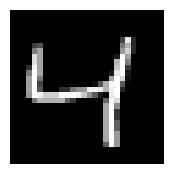

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(img4[0],cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img9 = train_images[train_labels==9]
img9 = (img9/127.5)-1.0
img9.shape

(5949, 28, 28)

There are 5949 images with label 9

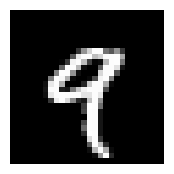

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(img9[0],cmap='gray')
plt.axis('off')
plt.show()

### Data Preprocessing

#### Resize Images to size (32,32)

In [ ]:
digit4_data = np.zeros((img4.shape[0],32,32))
for index,img in enumerate(img4):
  digit4_data[index,:,:] = resize(img,(32,32))
digit4_data.shape

(5842, 32, 32)

In [ ]:
digit9_data =np.zeros((img9.shape[0],32,32))
for index,img in enumerate(img9):
  digit9_data[index,:,:] = resize(img,(32,32,))
digit9_data.shape

(5949, 32, 32)

#### Reshape Images to (32,32,1) with float pixel values

In [ ]:
digit4_data = digit4_data.reshape(digit4_data.shape[0],32,32,1).astype('float32')
digit9_data = digit9_data.reshape(digit9_data.shape[0],32,32,1).astype('float32')

### Batcha and shuffle the data

In [ ]:
digit4_data = tf.data.Dataset.from_tensor_slices(digit4_data).shuffle(img4.shape[0],seed=42).batch(BATCH_SIZE)
digit9_data = tf.data.Dataset.from_tensor_slices(digit9_data).shuffle(img9.shape[0],seed=42).batch(BATCH_SIZE)

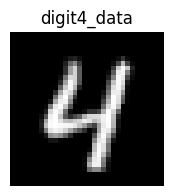

In [ ]:
sample_digit4_data = next(iter(digit4_data))
plt.figure(figsize=(2,2))
plt.imshow(sample_digit4_data[0].numpy()[:,:,0],cmap='gray')
plt.title('digit4_data')
plt.axis('off')
plt.show()

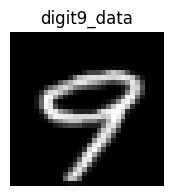

In [ ]:
sample_digit9_data = next(iter(digit9_data))
plt.figure(figsize=(2,2))
plt.imshow(sample_digit9_data[0].numpy()[:,:,0],cmap='gray')
plt.title('digit9_data')
plt.axis('off')
plt.show()

### Model Building
1. Instance Normalization
2. Downsampling,Upsampling and Unet
3. Generator Building using Unet
4. Discriminator Building

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling

In [ ]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

### Upsampling

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

### Unet Generator Function

In [ ]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(64, 4, False), # (bs, 16, 16, 64)
        downsample(128, 4), # (bs, 8, 8, 128)
        downsample(128, 4), # (bs, 4, 4, 128)
        downsample(128, 4), # (bs, 2, 2, 128)
        downsample(128, 4) # (bs, 1, 1, 128)
    ]
    up_stack = [
        upsample(128, 4, True), # (bs, 2, 2, 256)
        upsample(128, 4, True), # (bs, 4, 4, 256)
        upsample(128, 4), # (bs, 8, 8, 256)
        upsample(64, 4) # (bs, 16, 16, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[32, 32, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# Instantiate 2 generators
generator_g = unet_generator()
generator_f = unet_generator()

In [ ]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 16, 16, 64)           1024      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 8, 8, 128)            131328    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 4, 4, 128)            262400    ['sequential_1[0][0]']        
                                                                                              

### Discriminator

In [ ]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[32, 32, 1], name='input_image')
    x = inp

    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 10, 10, 128)

    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)

    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [ ]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 sequential_18 (Sequential)  (None, 16, 16, 64)        1024      
                                                                 
 sequential_19 (Sequential)  (None, 8, 8, 128)         131328    
                                                                 
 zero_padding2d (ZeroPaddin  (None, 10, 10, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 256)         524288    
                                                                 
 instance_normalization_17   (None, 7, 7, 256)         512       
 (InstanceNormalization)                                   

### Model Training
1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

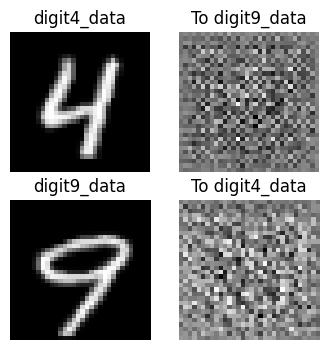

In [ ]:
to_digit9_data = generator_g(sample_digit4_data)
to_digit4_data = generator_f(sample_digit9_data)
plt.figure(figsize=(4, 4))

imgs = [sample_digit4_data, to_digit9_data, sample_digit9_data, to_digit4_data]
title = ['digit4_data', 'To digit9_data', 'digit9_data', 'To digit4_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

### Declare Loss as BinaryCrossEntropy
Since our Discriminator is a classifier

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss
It consists of two types of losses
1.    Loss on Real Data
2.    Loss on Fake Data

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

#### Generator Loss
It has only one type of loss - Discriminator Loss on Generated data

In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

#### Cycle Loss
When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

#### Identity Loss
When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

### Optimizer

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
EPOCHS=100

### Checkpoint Initialization

In [ ]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Training Flow

Sequence of Training Flow


1.   Generate Fake Y and Cycled X
2.   Generate Fake X and Cycled Y
3.   Generate Fake Images through G and F for Identity Loss.
4.   Calculate Discriminator Loss for Disc X and Disc Y on Fake Data for Generator Training.
5.   Calculate Generator Loss on Discriminator.
6.   Calculate Cycled Loss on Cycled Images from step 1 and 2.
7.   Calculate Total Generator Loss - Disc Loss + Cycled Loss + Identity Loss
8.   Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
9.   Calculate the Gradients and update the weight and bias of models.



In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

### Train the CycleGAN Model for several Epochs

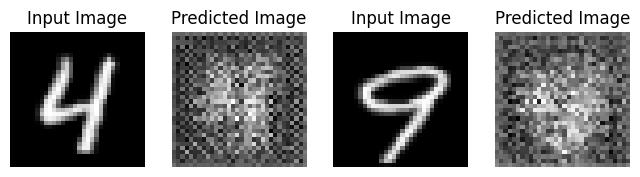

Saving checkpoint for epoch 1 at ./Trained_Model/ckpt-1


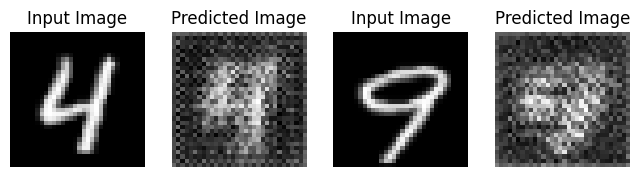

Saving checkpoint for epoch 2 at ./Trained_Model/ckpt-2


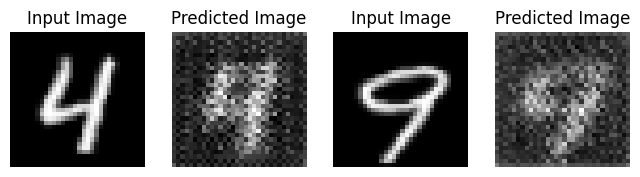

Saving checkpoint for epoch 3 at ./Trained_Model/ckpt-3


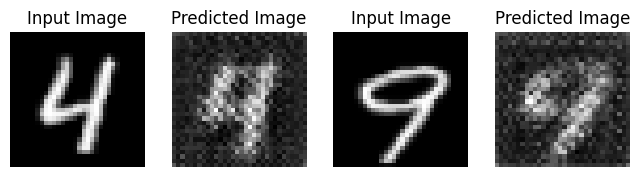

Saving checkpoint for epoch 4 at ./Trained_Model/ckpt-4


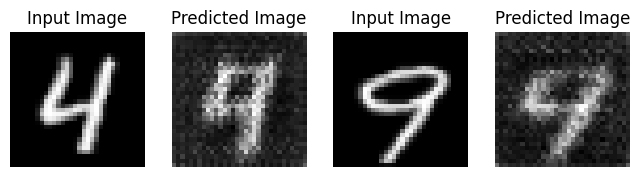

Saving checkpoint for epoch 5 at ./Trained_Model/ckpt-5


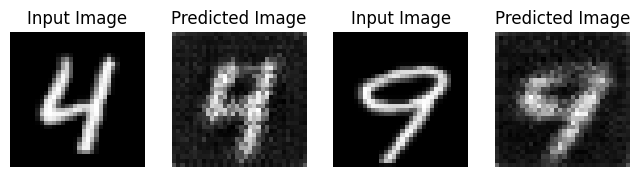

Saving checkpoint for epoch 6 at ./Trained_Model/ckpt-6


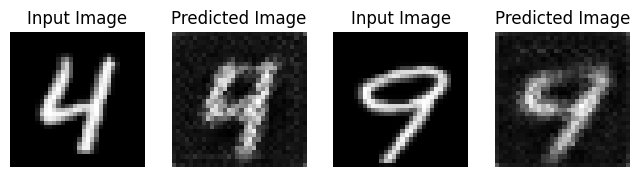

Saving checkpoint for epoch 7 at ./Trained_Model/ckpt-7


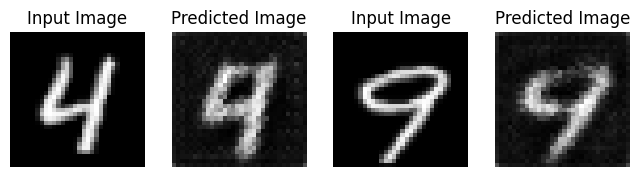

Saving checkpoint for epoch 8 at ./Trained_Model/ckpt-8


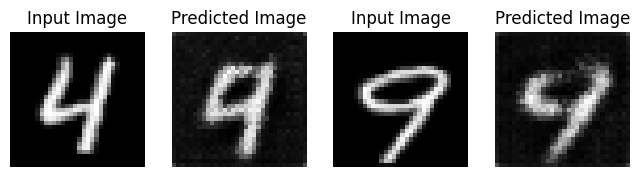

Saving checkpoint for epoch 9 at ./Trained_Model/ckpt-9


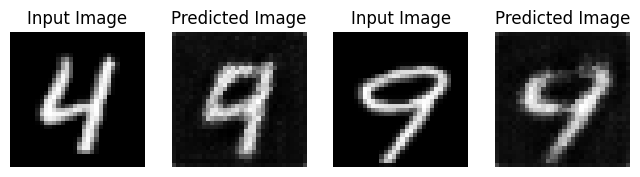

Saving checkpoint for epoch 10 at ./Trained_Model/ckpt-10


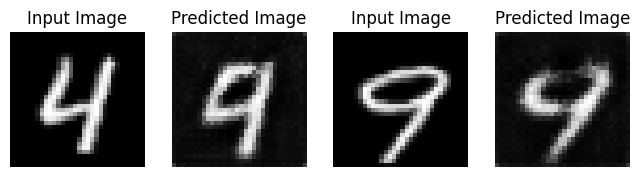

Saving checkpoint for epoch 11 at ./Trained_Model/ckpt-11


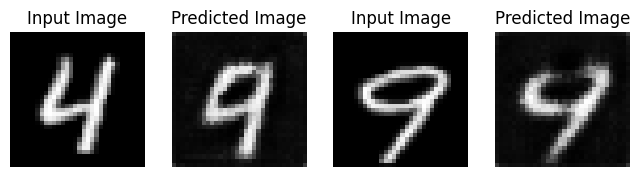

Saving checkpoint for epoch 12 at ./Trained_Model/ckpt-12


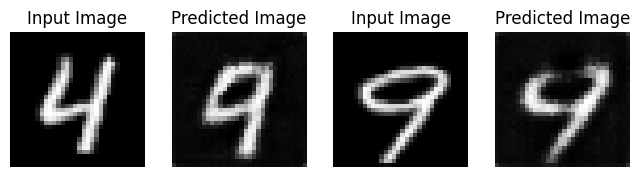

Saving checkpoint for epoch 13 at ./Trained_Model/ckpt-13


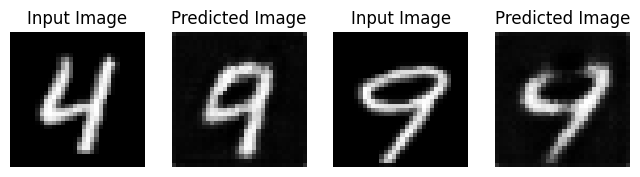

Saving checkpoint for epoch 14 at ./Trained_Model/ckpt-14


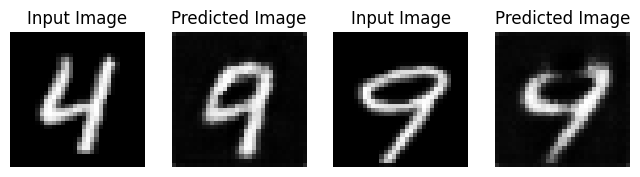

Saving checkpoint for epoch 15 at ./Trained_Model/ckpt-15


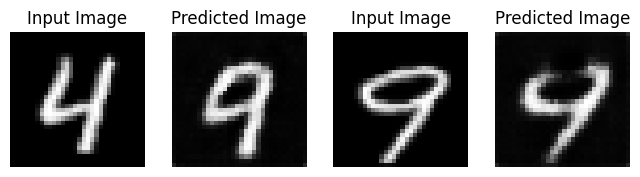

Saving checkpoint for epoch 16 at ./Trained_Model/ckpt-16


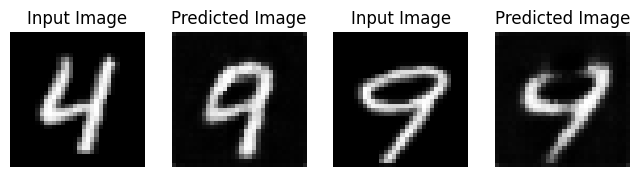

Saving checkpoint for epoch 17 at ./Trained_Model/ckpt-17


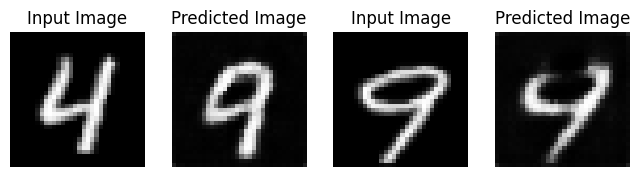

Saving checkpoint for epoch 18 at ./Trained_Model/ckpt-18


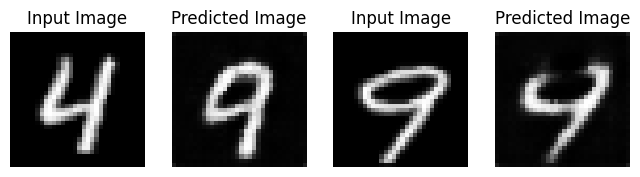

Saving checkpoint for epoch 19 at ./Trained_Model/ckpt-19


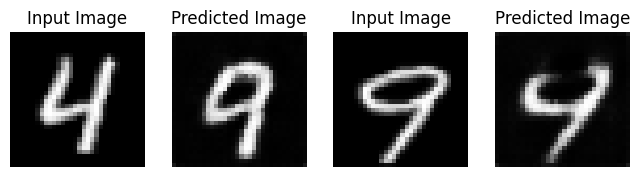

Saving checkpoint for epoch 20 at ./Trained_Model/ckpt-20


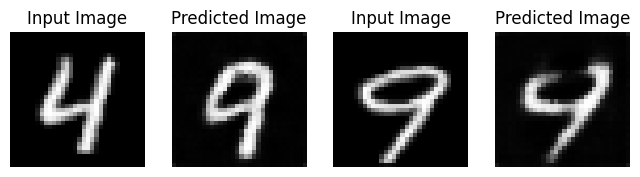

Saving checkpoint for epoch 21 at ./Trained_Model/ckpt-21


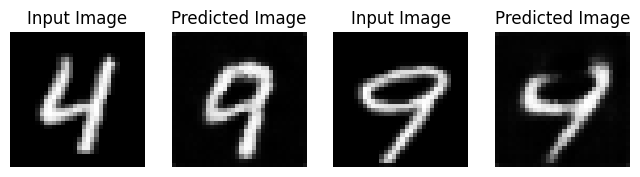

Saving checkpoint for epoch 22 at ./Trained_Model/ckpt-22


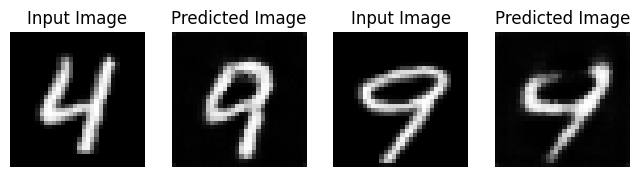

Saving checkpoint for epoch 23 at ./Trained_Model/ckpt-23


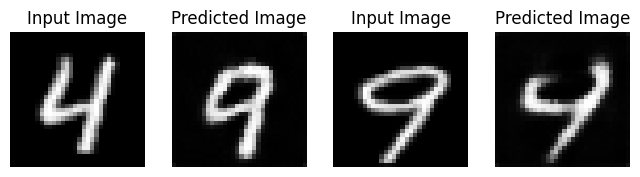

Saving checkpoint for epoch 24 at ./Trained_Model/ckpt-24


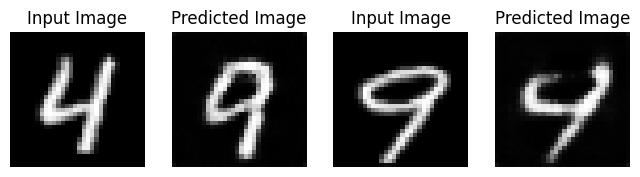

Saving checkpoint for epoch 25 at ./Trained_Model/ckpt-25


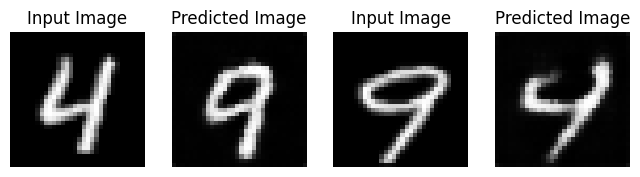

Saving checkpoint for epoch 26 at ./Trained_Model/ckpt-26


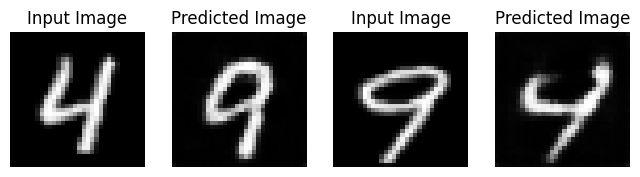

Saving checkpoint for epoch 27 at ./Trained_Model/ckpt-27


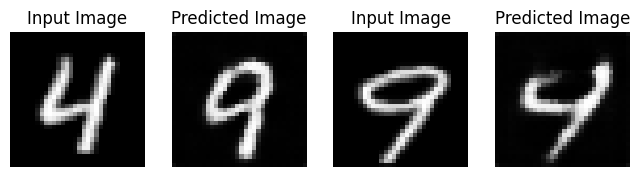

Saving checkpoint for epoch 28 at ./Trained_Model/ckpt-28


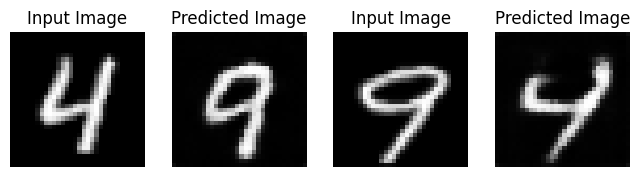

Saving checkpoint for epoch 29 at ./Trained_Model/ckpt-29


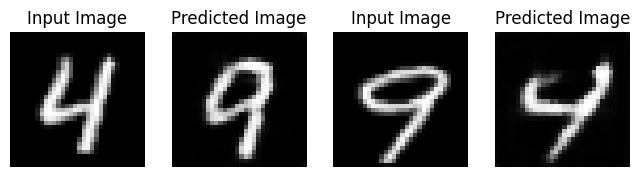

Saving checkpoint for epoch 30 at ./Trained_Model/ckpt-30


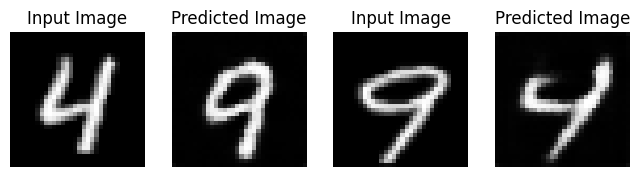

Saving checkpoint for epoch 31 at ./Trained_Model/ckpt-31


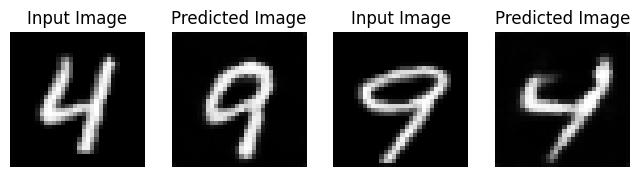

Saving checkpoint for epoch 32 at ./Trained_Model/ckpt-32


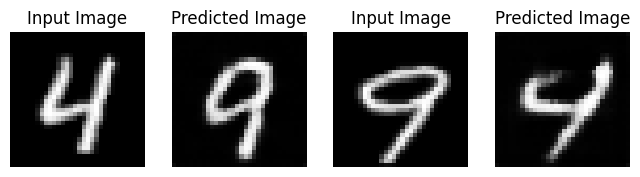

Saving checkpoint for epoch 33 at ./Trained_Model/ckpt-33


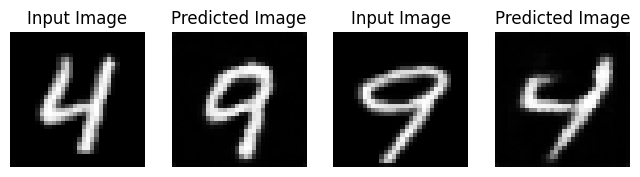

Saving checkpoint for epoch 34 at ./Trained_Model/ckpt-34


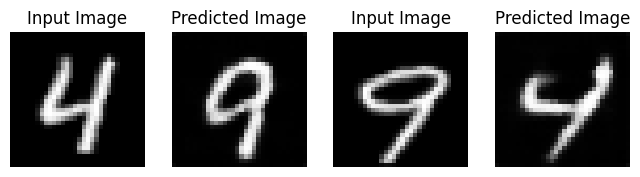

Saving checkpoint for epoch 35 at ./Trained_Model/ckpt-35


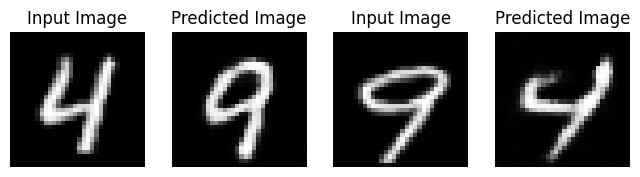

Saving checkpoint for epoch 36 at ./Trained_Model/ckpt-36


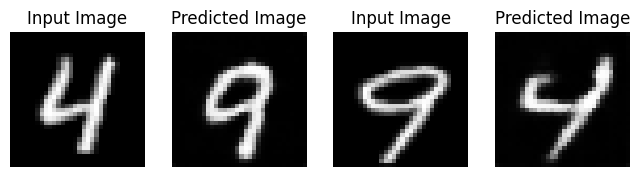

Saving checkpoint for epoch 37 at ./Trained_Model/ckpt-37


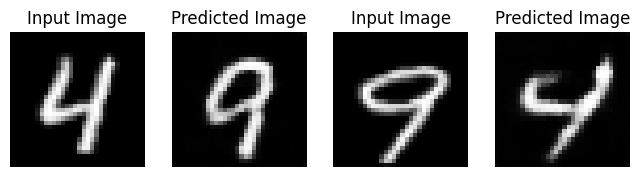

Saving checkpoint for epoch 38 at ./Trained_Model/ckpt-38


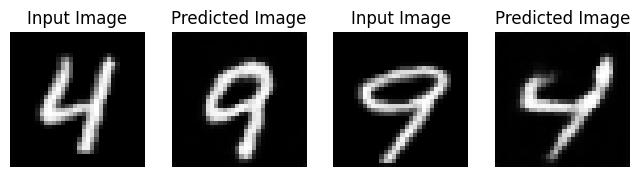

Saving checkpoint for epoch 39 at ./Trained_Model/ckpt-39


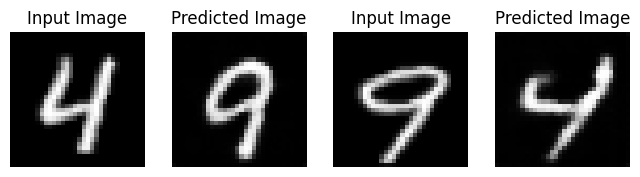

Saving checkpoint for epoch 40 at ./Trained_Model/ckpt-40


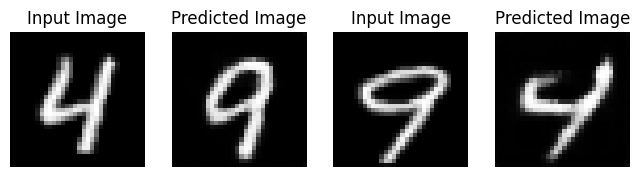

Saving checkpoint for epoch 41 at ./Trained_Model/ckpt-41


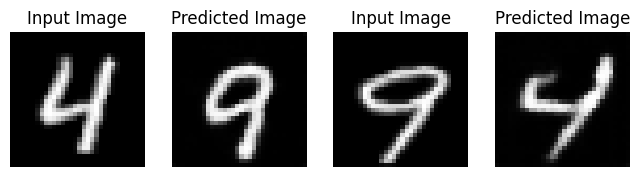

Saving checkpoint for epoch 42 at ./Trained_Model/ckpt-42


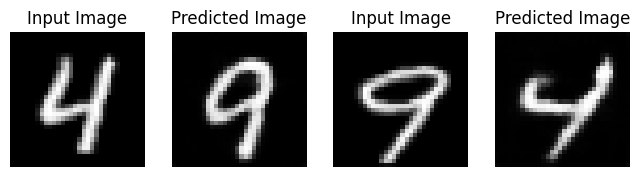

Saving checkpoint for epoch 43 at ./Trained_Model/ckpt-43


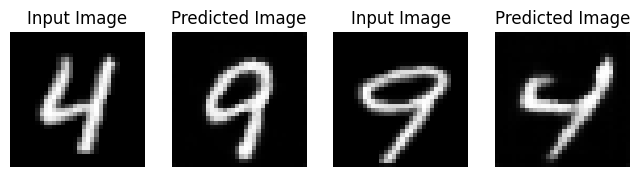

Saving checkpoint for epoch 44 at ./Trained_Model/ckpt-44


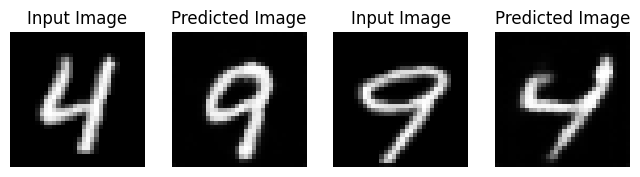

Saving checkpoint for epoch 45 at ./Trained_Model/ckpt-45


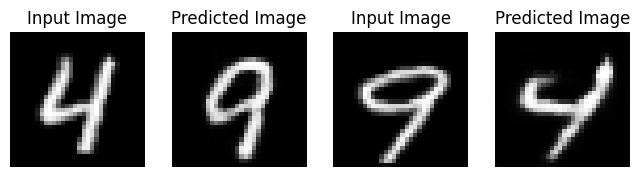

Saving checkpoint for epoch 46 at ./Trained_Model/ckpt-46


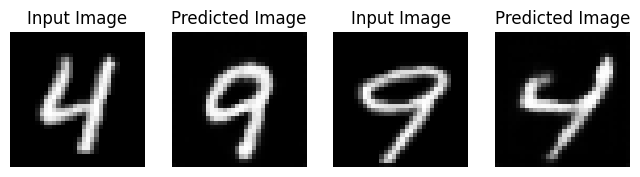

Saving checkpoint for epoch 47 at ./Trained_Model/ckpt-47


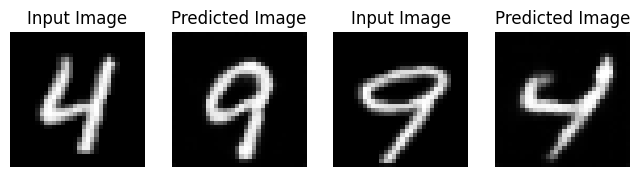

Saving checkpoint for epoch 48 at ./Trained_Model/ckpt-48


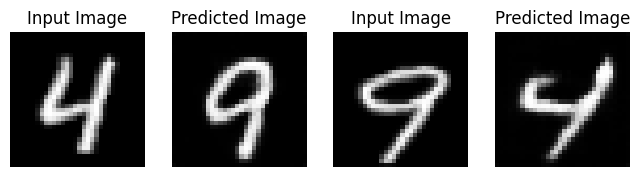

Saving checkpoint for epoch 49 at ./Trained_Model/ckpt-49


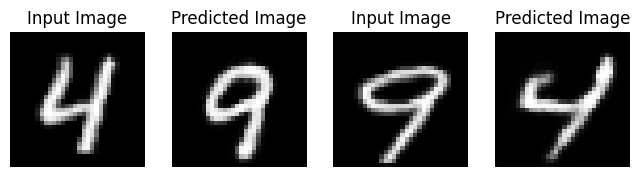

Saving checkpoint for epoch 50 at ./Trained_Model/ckpt-50


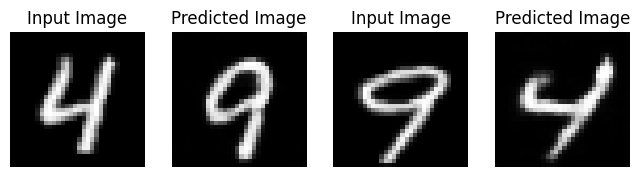

Saving checkpoint for epoch 51 at ./Trained_Model/ckpt-51


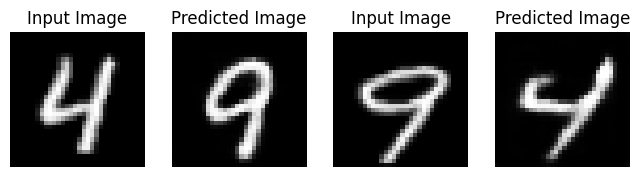

Saving checkpoint for epoch 52 at ./Trained_Model/ckpt-52


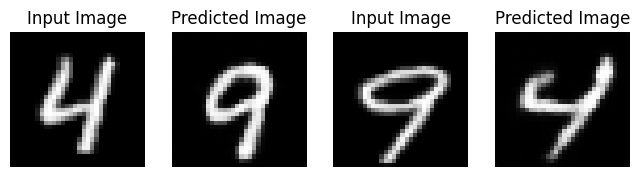

Saving checkpoint for epoch 53 at ./Trained_Model/ckpt-53


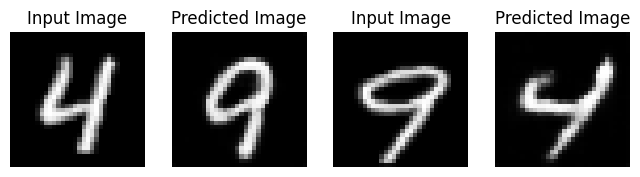

Saving checkpoint for epoch 54 at ./Trained_Model/ckpt-54


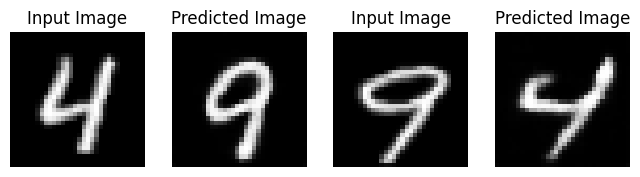

Saving checkpoint for epoch 55 at ./Trained_Model/ckpt-55


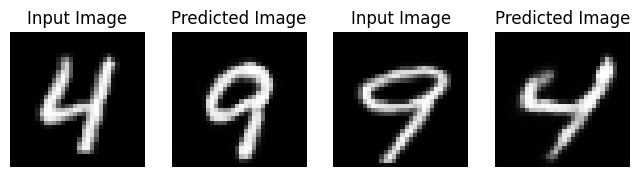

Saving checkpoint for epoch 56 at ./Trained_Model/ckpt-56


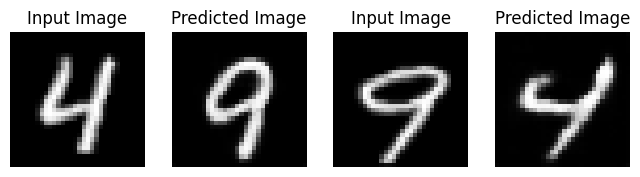

Saving checkpoint for epoch 57 at ./Trained_Model/ckpt-57


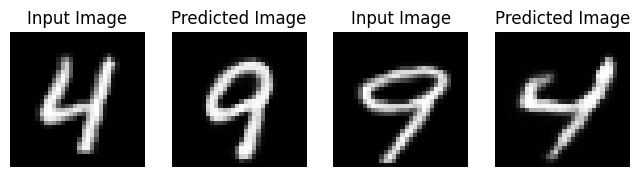

Saving checkpoint for epoch 58 at ./Trained_Model/ckpt-58


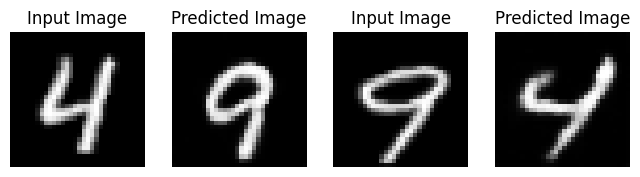

Saving checkpoint for epoch 59 at ./Trained_Model/ckpt-59


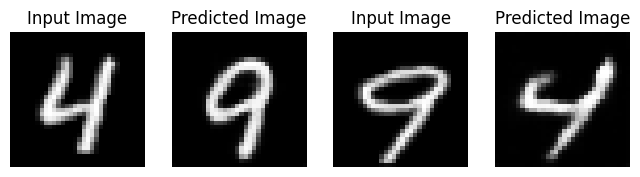

Saving checkpoint for epoch 60 at ./Trained_Model/ckpt-60


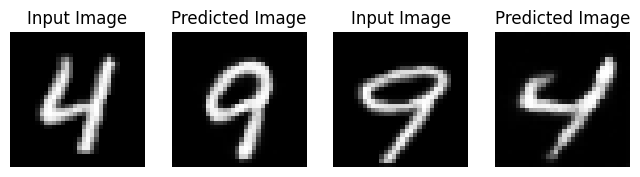

Saving checkpoint for epoch 61 at ./Trained_Model/ckpt-61


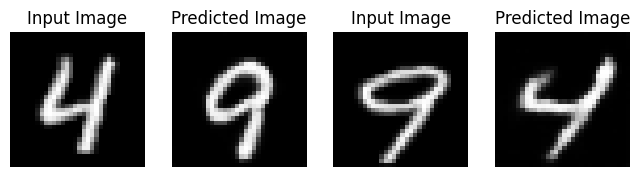

Saving checkpoint for epoch 62 at ./Trained_Model/ckpt-62


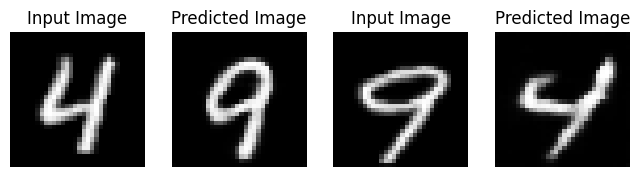

Saving checkpoint for epoch 63 at ./Trained_Model/ckpt-63


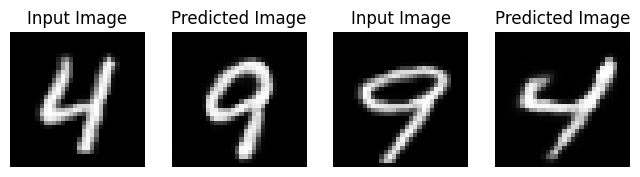

Saving checkpoint for epoch 64 at ./Trained_Model/ckpt-64


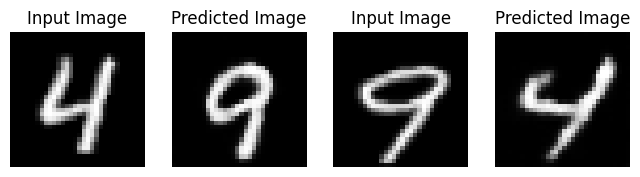

Saving checkpoint for epoch 65 at ./Trained_Model/ckpt-65


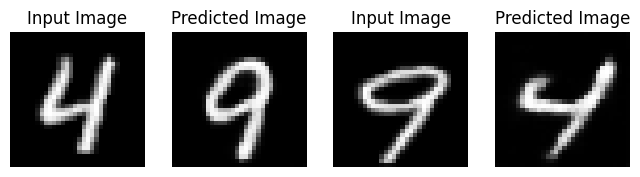

Saving checkpoint for epoch 66 at ./Trained_Model/ckpt-66


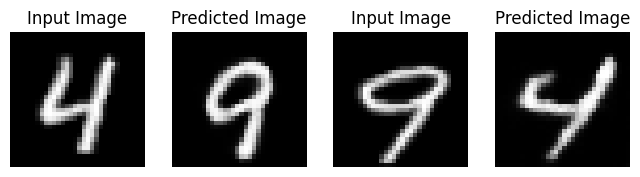

Saving checkpoint for epoch 67 at ./Trained_Model/ckpt-67


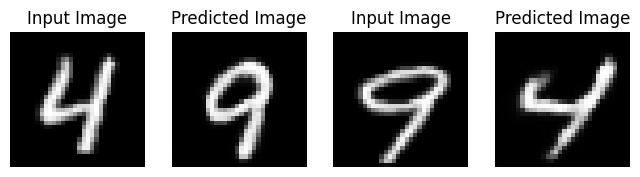

Saving checkpoint for epoch 68 at ./Trained_Model/ckpt-68


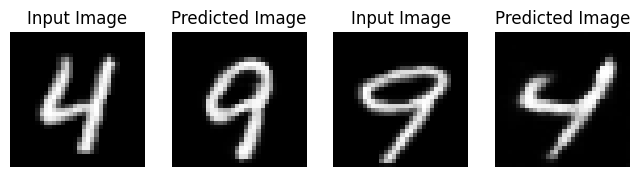

Saving checkpoint for epoch 69 at ./Trained_Model/ckpt-69


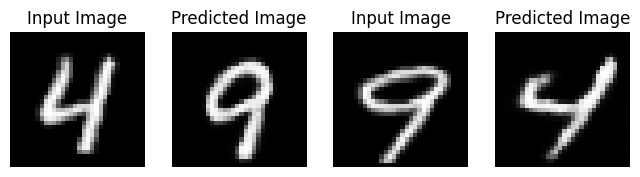

Saving checkpoint for epoch 70 at ./Trained_Model/ckpt-70


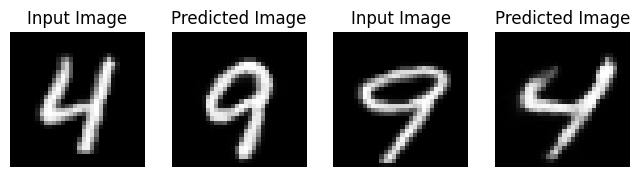

Saving checkpoint for epoch 71 at ./Trained_Model/ckpt-71


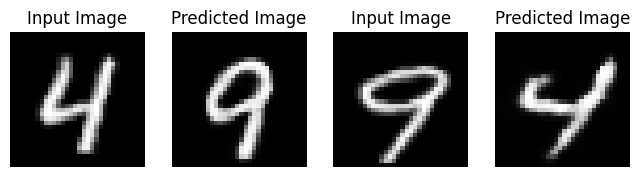

Saving checkpoint for epoch 72 at ./Trained_Model/ckpt-72


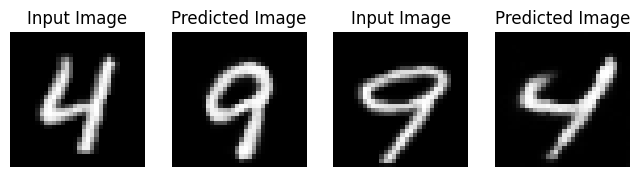

Saving checkpoint for epoch 73 at ./Trained_Model/ckpt-73


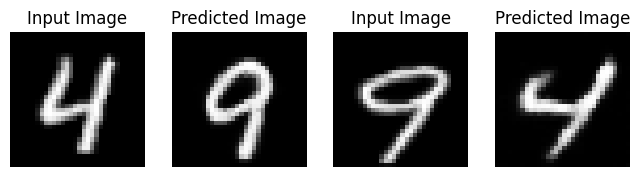

Saving checkpoint for epoch 74 at ./Trained_Model/ckpt-74


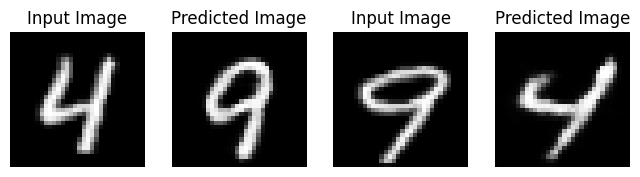

Saving checkpoint for epoch 75 at ./Trained_Model/ckpt-75


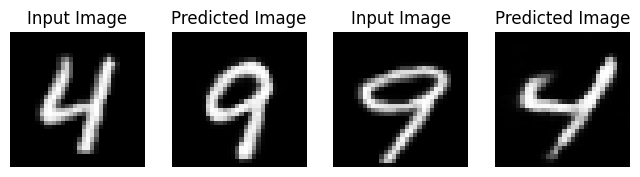

Saving checkpoint for epoch 76 at ./Trained_Model/ckpt-76


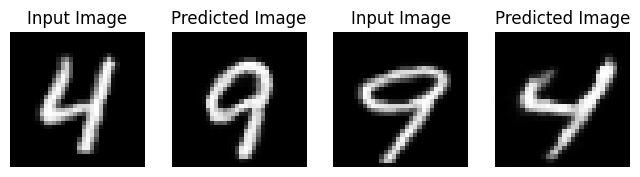

Saving checkpoint for epoch 77 at ./Trained_Model/ckpt-77


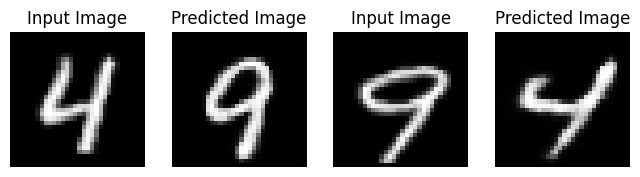

Saving checkpoint for epoch 78 at ./Trained_Model/ckpt-78


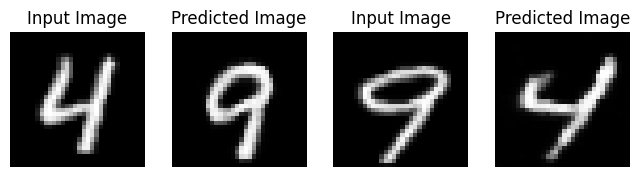

Saving checkpoint for epoch 79 at ./Trained_Model/ckpt-79


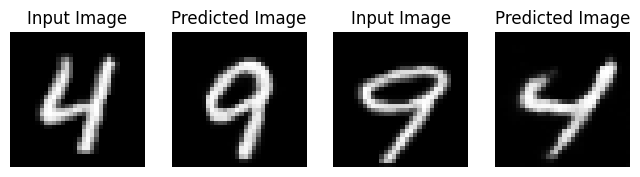

Saving checkpoint for epoch 80 at ./Trained_Model/ckpt-80


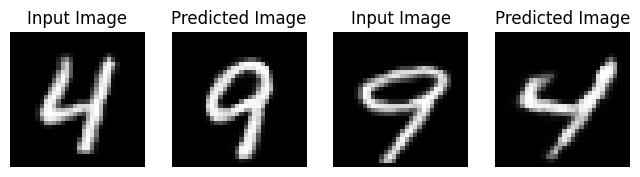

Saving checkpoint for epoch 81 at ./Trained_Model/ckpt-81


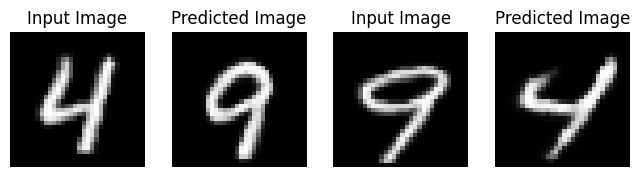

Saving checkpoint for epoch 82 at ./Trained_Model/ckpt-82


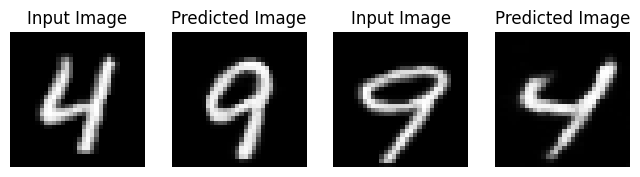

Saving checkpoint for epoch 83 at ./Trained_Model/ckpt-83


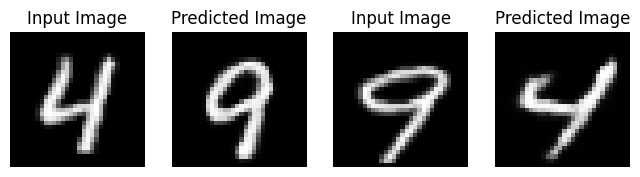

Saving checkpoint for epoch 84 at ./Trained_Model/ckpt-84


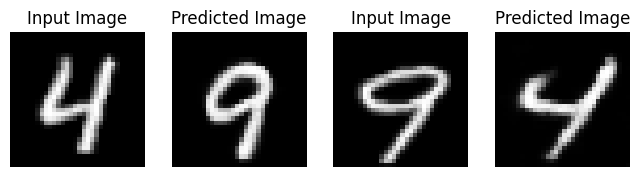

Saving checkpoint for epoch 85 at ./Trained_Model/ckpt-85


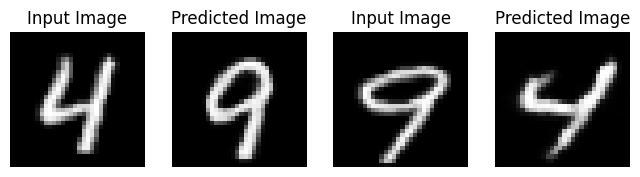

Saving checkpoint for epoch 86 at ./Trained_Model/ckpt-86


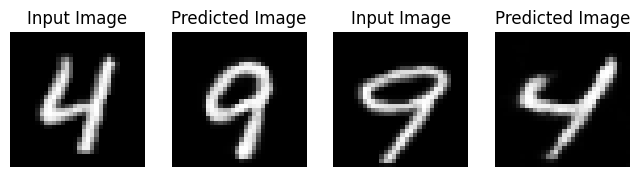

Saving checkpoint for epoch 87 at ./Trained_Model/ckpt-87


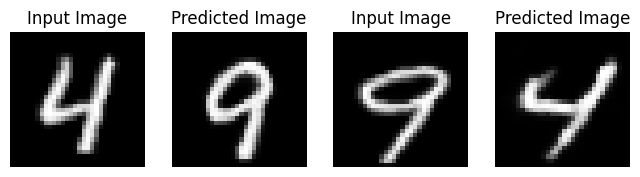

Saving checkpoint for epoch 88 at ./Trained_Model/ckpt-88


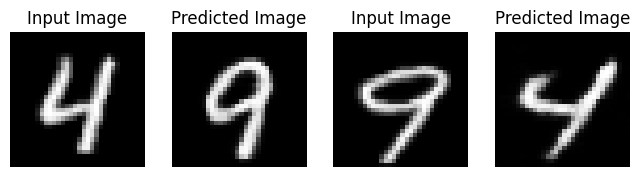

Saving checkpoint for epoch 89 at ./Trained_Model/ckpt-89


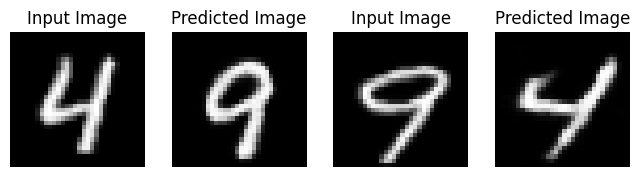

Saving checkpoint for epoch 90 at ./Trained_Model/ckpt-90


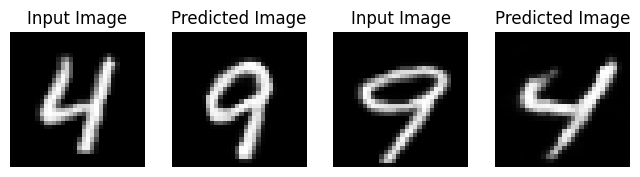

Saving checkpoint for epoch 91 at ./Trained_Model/ckpt-91


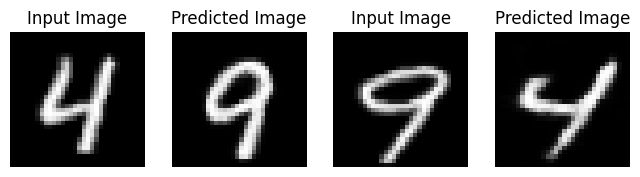

Saving checkpoint for epoch 92 at ./Trained_Model/ckpt-92


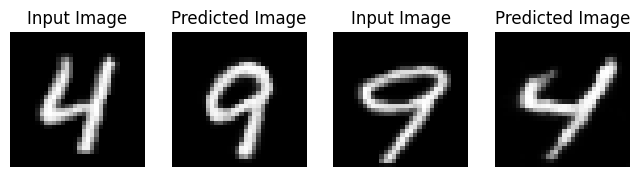

Saving checkpoint for epoch 93 at ./Trained_Model/ckpt-93


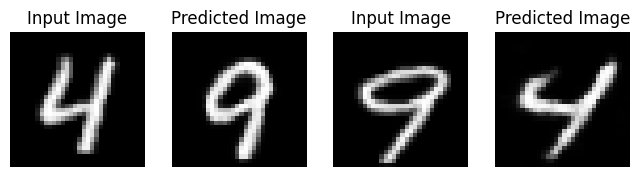

Saving checkpoint for epoch 94 at ./Trained_Model/ckpt-94


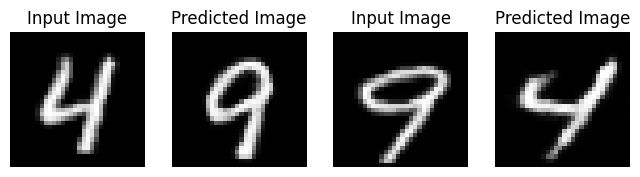

Saving checkpoint for epoch 95 at ./Trained_Model/ckpt-95


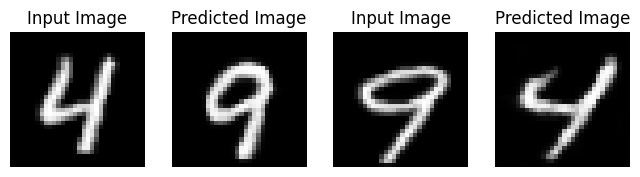

Saving checkpoint for epoch 96 at ./Trained_Model/ckpt-96


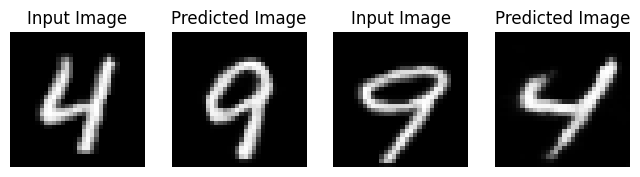

Saving checkpoint for epoch 97 at ./Trained_Model/ckpt-97


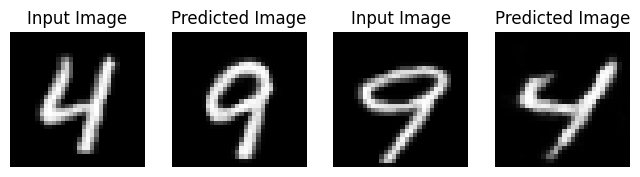

Saving checkpoint for epoch 98 at ./Trained_Model/ckpt-98


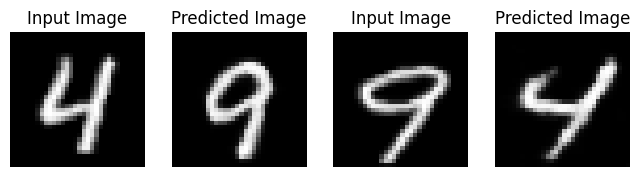

Saving checkpoint for epoch 99 at ./Trained_Model/ckpt-99


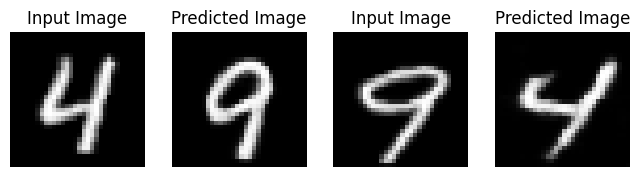

Saving checkpoint for epoch 100 at ./Trained_Model/ckpt-100


In [ ]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((digit4_data, digit9_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_digit4_data, generator_f, sample_digit9_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Generating a GIF for visualization of Results

In [ ]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-35-b4ad71c1b2ad>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-35-b4ad71c1b2ad>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-qo4im2xh
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-qo4im2xh
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=601039ac0afd279e9e721e6803c2b5edb705b543b537b051f593e189e99ba967
  Stored in directory: /tmp/pip-ephem-wheel-cache-o9py3sg2/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs



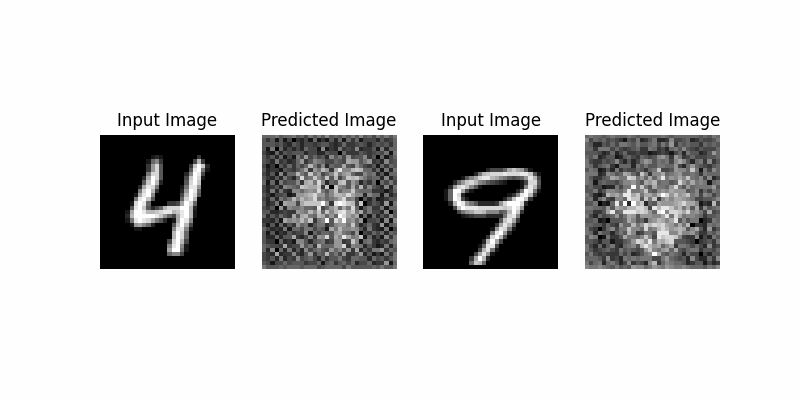

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)